# Titanic Dataset

## This notebook contains the code used to generate the results that were submitted to Kaggle. It is a compilation/selection of parts of the other notebooks in this repository.

### The analysis steps are split into:
1. Dataset cleaning and preparation
2. Model building and validation
3. Model application to test dataset

In [76]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
plt.rcParams.update({'font.size': 16})

## 1. Data cleaning and preparation

In [78]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [79]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1.1 Data summary
| Variable | Description | Notes |
| :- | :- | :- |
| PassengerId | | Irrelevant information for classification, however an important spectator for final cross-checking |
| Survived | Boolean coded as integer - 0 or 1 | Class label |
| Pclass | Ticket class | |
| Name | | Irrelevant information for classification and redundant with PassengerId - must be **dropped** |
| Sex | Passenger gender | Categorical data to be turned into dummies |
| Age | Passenger Age | Ordinal variable |
| SibSp | # of siblings / spouses aboard the Titanic | Ordinal variable |
| Parch | # of parents / children aboard the Titanic | Ordinal variable |
| Ticket | Ticket number | The level of relevance is not clear | 
| Fare | Passenger fare | The level of relevance is not clear |
| Cabin | Cabin number | Very likely irrelevant |
| Embark | Port of Embarkation (C, Q or S) | |

### 1.2 Data cleaning - dropping irrelevant variables 

In [81]:
data_train = data_train.drop(columns='Name')
data_test = data_test.drop(columns='Name')

### 1.3 Inspecting single variable distributions

In [82]:
## Plotting first numerical variables
variables_to_plot = list(data_train.columns)
variables_to_plot.remove('PassengerId')

# Selecting categorical variables from columns
categorical_variables = data_train.select_dtypes(exclude=['number','bool_']).columns

# Removing categorical variables from list of variables to plot
for v in categorical_variables:
    variables_to_plot.remove(v)

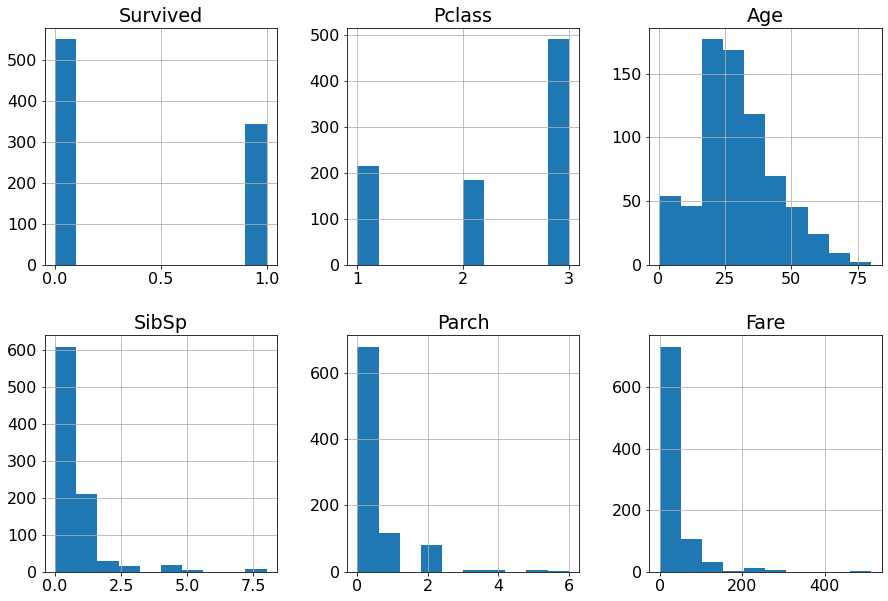

In [83]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.flatten()

for var, ax in zip(variables_to_plot, axs):
    data_train.hist(var, ax=ax)

***
#### Interpretation

The numerical variable distributions look all well behaved and no outline is present.
***

In [84]:
## Inspecting categorical variables

for var in categorical_variables:
    c = data_train[var].value_counts()
    print('Variable: {}'.format(var))
    print('Len: {}'.format(len(c)))

Variable: Sex
Len: 2
Variable: Ticket
Len: 681
Variable: Cabin
Len: 147
Variable: Embarked
Len: 3


***
#### Interpretation

Variables Sex and Embarked contain few values, therefore they can be easily encoded through one-hot encoding.

Cabin and Embarked contain a large number of values, therefore one-hot encoding is not an option. These variables will demand specific treatment.
***

### 1.4 Handling Cabin variable

In [85]:
# Calculating the ratio of NaN's
nan_ratio = data_train['Cabin'].isna().sum() / len(data_train['Cabin'])
print(nan_ratio)

0.7710437710437711


Since 77% of the examples are missing the Cabin value, I will create another variable to tell whether the example has a cabin number or not. Hopefully this new variable will contain useful information.

In [86]:
data_train['HasCabin'] = data_train['Cabin'].isna()
data_test['HasCabin'] = data_test['Cabin'].isna()

data_train = data_train.drop(columns='Cabin')
data_test = data_test.drop(columns='Cabin')

### 1.5 Handling Ticket variable

In [87]:
np.unique(data_train['Ticket'].values)

array(['110152', '110413', '110465', '110564', '110813', '111240',
       '111320', '111361', '111369', '111426', '111427', '111428',
       '112050', '112052', '112053', '112058', '112059', '112277',
       '112379', '113028', '113043', '113050', '113051', '113055',
       '113056', '113059', '113501', '113503', '113505', '113509',
       '113510', '113514', '113572', '113760', '113767', '113773',
       '113776', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113792', '113794', '113796', '113798',
       '113800', '113803', '113804', '113806', '113807', '11668', '11751',
       '11752', '11753', '11755', '11765', '11767', '11769', '11771',
       '11774', '11813', '11967', '12233', '12460', '12749', '13049',
       '13213', '13214', '13502', '13507', '13509', '13567', '13568',
       '14311', '14312', '14313', '14973', '1601', '16966', '16988',
       '17421', '17453', '17463', '17464', '17465', '17466', '17474',
       '17764', '19877', '19928', '19943

Ticket variable contains entries in different formats, some are numbers, some are number + a certain letter pattern. I will try to recover some information from the Ticket variable by creating another variable that tells whether the Ticket is a number or not.

In [88]:
def is_ticket_number(x):
    try:
        float(x)
        return 1
    except ValueError:
        return 0

<AxesSubplot:>

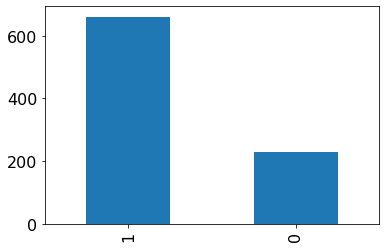

In [89]:
# Applying is_ticket_number
data_train['IsTicketNumber'] = data_train['Ticket'].map(is_ticket_number)
data_test['IsTicketNumber'] = data_test['Ticket'].map(is_ticket_number)

data_train = data_train.drop(columns='Ticket')
data_test = data_test.drop(columns='Ticket')

data_train['IsTicketNumber'].value_counts().plot(kind='bar')

### 1.6 Handling missing values

In [90]:
for col in data_train.columns:
    nan_ratio = np.sum(data_train[col].isna()) / len(data_train)
    print('Col {}, missing ratio = {:.4f}'.format(col, nan_ratio))

Col PassengerId, missing ratio = 0.0000
Col Survived, missing ratio = 0.0000
Col Pclass, missing ratio = 0.0000
Col Sex, missing ratio = 0.0000
Col Age, missing ratio = 0.1987
Col SibSp, missing ratio = 0.0000
Col Parch, missing ratio = 0.0000
Col Fare, missing ratio = 0.0000
Col Embarked, missing ratio = 0.0022
Col HasCabin, missing ratio = 0.0000
Col IsTicketNumber, missing ratio = 0.0000


***
Most of the missing data (20%) comes from the Age variable, which is an important source of information.
The remaining missing data (<2%) comes from Embarked.

I do not intend to remove any data because of missing values. Instead I will handle them by creating extra variables to indicate whether these variables are filled or not.

Age will be handled by replacing NaN's by -1 and creating a new variable HasAge.

Embarked will be handled by replacing NaN's with a categorical value 'unknown'. The Embarked variable will be later replaced by one-hot encoded ones.
***

In [91]:
# Handling Age variable
# A Variable HasAge will be created and the missing values will be filled wit -1
data_train['HasAge'] = data_train['Age'].notna()
data_test['HasAge'] = data_test['Age'].notna()

In [92]:
def process_nan_age(x):
    if np.isnan(x):
        return -1
    else:
        return x

In [93]:
data_train['Age'] = data_train['Age'].map(process_nan_age)
data_test['Age'] = data_test['Age'].map(process_nan_age)

In [94]:
# Handling Embarked variable
def process_nan_embarked(x):
    if x not in ['C', 'S', 'Q']:
        return 'unknown'
    else:
        return x

In [95]:
data_train['Embarked'] = data_train['Embarked'].map(process_nan_embarked)
data_test['Embarked'] = data_test['Embarked'].map(process_nan_embarked)

### 1.7 Encoding categorical variables

In [96]:
# Sex
df = pd.get_dummies(data_train['Sex'], drop_first=True)
data_train['IsMale'] = df['male']
data_train = data_train.drop(columns='Sex')

In [97]:
df = pd.get_dummies(data_test['Sex'], drop_first=True)
data_test['IsMale'] = df['male']
data_test = data_test.drop(columns='Sex')

In [98]:
# Embarked
df = pd.get_dummies(data_train['Embarked'], drop_first=True)

data_train['EmbarkedQ'] = df['Q']
data_train['EmbarkedS'] = df['S']
data_train['EmbarkedU'] = df['unknown']

In [99]:
df = pd.get_dummies(data_test['Embarked'], drop_first=True)

data_test['EmbarkedQ'] = df['Q']
data_test['EmbarkedS'] = df['S']
data_test['EmbarkedU'] = 0

In [100]:
data_train = data_train.drop(columns='Embarked')
data_test = data_test.drop(columns='Embarked')

In [101]:
# Pclass
df = pd.get_dummies(data_train['Pclass'], prefix='class', drop_first=False)
data_train['IsFirstClass'] = df['class_1']
data_train['IsSecondClass'] = df['class_2']

In [102]:
df = pd.get_dummies(data_test['Pclass'], prefix='class', drop_first=False)
data_test['IsFirstClass'] = df['class_1']
data_test['IsSecondClass'] = df['class_2']

In [103]:
data_train = data_train.drop(columns='Pclass')
data_test = data_test.drop(columns='Pclass')

In [104]:
# HasCabin
df = pd.get_dummies(data_train['HasCabin'], prefix='cabin', drop_first=False)
data_train['HasCabin'] = df['cabin_True']

df = pd.get_dummies(data_test['HasCabin'], prefix='cabin', drop_first=False)
data_test['HasCabin'] = df['cabin_True']

In [105]:
# HasAge
df = pd.get_dummies(data_train['HasAge'], prefix='age', drop_first=False)
data_train['HasAge'] = df['age_True']

df = pd.get_dummies(data_test['HasAge'], prefix='age', drop_first=False)
data_test['HasAge'] = df['age_True']

***
After encoding, all variables are numerical type now. Let's have a look at the current state of our dataset.
***

### 1.8 Final look at the dataset

In [106]:
data_train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,HasCabin,IsTicketNumber,HasAge,IsMale,EmbarkedQ,EmbarkedS,EmbarkedU,IsFirstClass,IsSecondClass
0,1,0,22.0,1,0,7.2500,1,0,1,1,0,1,0,0,0
1,2,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,1,0
2,3,1,26.0,0,0,7.9250,1,0,1,0,0,1,0,0,0
3,4,1,35.0,1,0,53.1000,0,1,1,0,0,1,0,1,0
4,5,0,35.0,0,0,8.0500,1,1,1,1,0,1,0,0,0


## 2. Classification model building and validation

In [107]:
from sklearn.model_selection import (
    GridSearchCV,
    validation_curve,
    learning_curve
)
from sklearn.ensemble import RandomForestClassifier

In [108]:
# Data preparation
X_train = data_train.drop(columns=['PassengerId', 'Survived'])
y_train = data_train['Survived']

In [109]:
clf = RandomForestClassifier(random_state=1, max_depth=4, criterion='entropy')

In [110]:
# Parameters dict for GridSearchCV
parameters = {
    'class_weight': [None, 'balanced'],
    'criterion': ['entropy', 'gini'],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [111]:
gs = GridSearchCV(
    clf,
    param_grid=parameters,
    n_jobs=5,
    return_train_score=True
)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy', max_depth=4,
                                              random_state=1),
             n_jobs=5,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['entropy', 'gini'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             return_train_score=True)

In [112]:
print('Best Score: {:.4f}'.format(gs.best_score_))
print('Best Parameters: ', gs.best_params_)

Best Score: 0.8070
Best Parameters:  {'class_weight': None, 'criterion': 'entropy', 'max_features': 'auto'}


In [113]:
best_clf = gs.best_estimator_

### Validation Curve (param: max_depth)

In [114]:
param_range = range(2, 10)
train_scores, test_scores = validation_curve(
    estimator=best_clf, 
    X=X_train,
    y=y_train,
    param_name='max_depth', 
    param_range=param_range,
    cv=5
)

In [115]:
def get_score_means_and_errors(train_scores, test_scores, stat_error=True):
    train_score_mean = np.mean(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)

    if stat_error:
        train_score_error = np.std(train_scores, axis=1) / np.sqrt(len(train_scores[0]))
        test_score_error = np.std(test_scores, axis=1) / np.sqrt(len(test_scores[0]))
    else:
        train_score_error = np.std(train_scores, axis=1)
        test_score_error = np.std(test_scores, axis=1)

    return train_score_mean, train_score_error, test_score_mean, test_score_error

In [116]:
train_score_mean, train_score_error, test_score_mean, test_score_error = \
        get_score_means_and_errors(train_scores, test_scores, stat_error=False)

In [117]:
COLORS = {'train': 'b', 'test': 'r'}

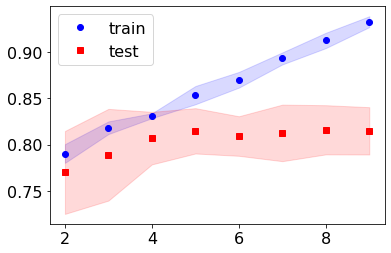

In [118]:
ax = plt.gca()
ax.plot(
    param_range,
    train_score_mean,
    color=COLORS['train'],
    linestyle='none',
    marker='o',
    label='train'
)
plt.fill_between(
    param_range,
    train_score_mean + train_score_error,
    train_score_mean - train_score_error,
    alpha=0.15,
    color=COLORS['train']
)
ax.plot(
    param_range,
    test_score_mean,
    color=COLORS['test'],
    linestyle='none',
    marker='s',
    label='test'
)
plt.fill_between(
    param_range,
    test_score_mean + test_score_error,
    test_score_mean - test_score_error,
    alpha=0.15,
    color=COLORS['test']
)
ax.legend()

Optimal max_depth = 4

### Learning Curve

In [119]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_clf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1, 10),
    cv=5
)

In [120]:
 train_score_mean, train_score_error, test_score_mean, test_score_error = \
        get_score_means_and_errors(train_scores, test_scores, stat_error=False)

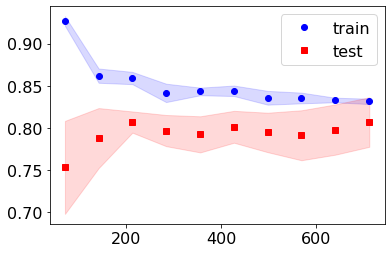

In [121]:
ax = plt.gca()
ax.plot(
    train_sizes,
    train_score_mean,
    color=COLORS['train'],
    linestyle='none',
    marker='o',
    label='train'
)
plt.fill_between(
    train_sizes,
    train_score_mean + train_score_error,
    train_score_mean - train_score_error,
    alpha=0.15,
    color=COLORS['train']
)
ax.plot(
    train_sizes,
    test_score_mean,
    color=COLORS['test'],
    linestyle='none',
    marker='s',
    label='test'
)
plt.fill_between(
    train_sizes,
    test_score_mean + test_score_error,
    test_score_mean - test_score_error,
    alpha=0.15,
    color=COLORS['test']
)
ax.legend()

In [122]:
print('TestScore = {:.4f} +/- {:.4f}'.format(test_score_mean[-1], test_score_error[-1]))

TestScore = 0.8070 +/- 0.0294


### Feature Importances

Text(0, 0.5, 'feature importance')

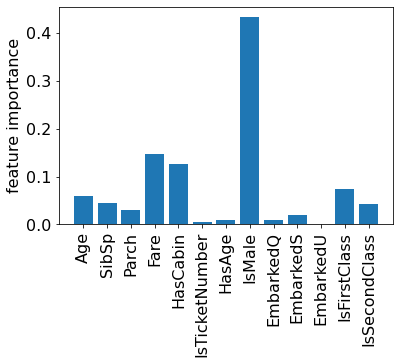

In [123]:
ax = plt.gca()
ax.bar(
    range(len(best_clf.feature_importances_)),
    best_clf.feature_importances_
)

ax.set_xticks(range(len(best_clf.feature_importances_)))
ax.set_xticklabels(list(X_train.columns), rotation=90)
ax.set_ylabel('feature importance')

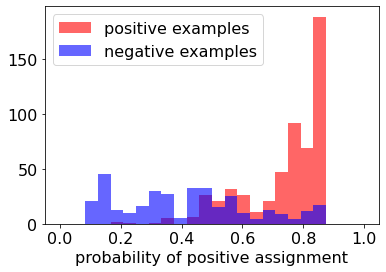

In [124]:
ax = plt.gca()
prob = best_clf.predict_proba(X_train)
ax.hist(
    [p for p, y in zip(prob[:,0], y_train) if y == 0],
    bins=np.linspace(0, 1, 25),
    alpha=0.6,
    color='r',
    label='positive examples'
)
ax.hist(
    [p for p, y in zip(prob[:,0], y_train) if y == 1],
    bins=np.linspace(0, 1, 25),
    alpha=0.6,
    color='b',
    label='negative examples'
)

ax.set_xlabel('probability of positive assignment')
ax.legend()

# 3. Applying model to test dataset

In [128]:
data_test = data_test.dropna()
data_test.isna().sum()

PassengerId       0
Age               0
SibSp             0
Parch             0
Fare              0
HasCabin          0
IsTicketNumber    0
HasAge            0
IsMale            0
EmbarkedQ         0
EmbarkedS         0
EmbarkedU         0
IsFirstClass      0
IsSecondClass     0
dtype: int64

In [129]:
X_ID = data_test['PassengerId']
X_test = data_test.drop(columns='PassengerId')

Age               0
SibSp             0
Parch             0
Fare              0
HasCabin          0
IsTicketNumber    0
HasAge            0
IsMale            0
EmbarkedQ         0
EmbarkedS         0
EmbarkedU         0
IsFirstClass      0
IsSecondClass     0
dtype: int64

In [131]:
y_pred = best_clf.predict(X_test)

In [132]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,